## Original data is misformatted

Fix it by removing the 

```<?xml version="1.0" encoding="utf-8"?>```

from every line and adding root.

We go from __01_fill_output_cleaned.xml__ to __02_data.xml__.

In [8]:
import codecs
data_folder = '/home/daniel/s2ds/Data/'
raw_file = codecs.open(data_folder + '01_full_output_cleaned.xml', 'rU', 'utf-8')
cleaned_file = codecs.open(data_folder + '02_data.xml', 'w', 'utf-8')
cleaned_file.write('<?xml version="1.0" encoding="utf-8"?>\n<root>\n')
for i in raw_file:
    if i[:4]!='<?xm':
        cleaned_file.write(i)
cleaned_file.write('</root>')
cleaned_file.close()

### Create test dataset for testing parsing

In [ ]:
import codecs
data_folder = '/home/daniel/s2ds/Data/'
raw_file = codecs.open(data_folder + '01_full_output_cleaned.xml', 'rU', 'utf-8')
cleaned_file = codecs.open(data_folder + '02_data_test.xml', 'w', 'utf-8')
cleaned_file.write('<?xml version="1.0" encoding="utf-8"?>\n<root>\n')
for i, l in enumerate(raw_file):
    if i < 1000:
        if l[:4]!='<?xm':
            cleaned_file.write(l)
cleaned_file.write('</root>')
cleaned_file.close()

## Parse the XML to get client - agent messages

Get touples of client-agent conversation bits from XML formatted chats. This will produce __03_clientMessages.txt__ and __03_agentMessages.txt__.

Also save the length of coversation and ID of conversation in __03_convLen.txt__ and __03_convNum.txt__, plus weather an external agent (customer service guy who has more specific knowledge about the customer's problem) took over the conversation from the original agent (saved to __03_externalAgent.txt__).

In [10]:
from bs4 import BeautifulSoup  # xml parsing library

# open files
client_messages_file = codecs.open(data_folder + '03_clientMessages.txt', 'a', 'utf-8')
agent_messages_file = codecs.open(data_folder + '03_agentMessages.txt', 'a', 'utf-8')
conversation_num_file = codecs.open(data_folder + '03_convNum.txt', 'a', 'utf-8')
conversation_len_file = codecs.open(data_folder + '03_convLen.txt', 'a', 'utf-8')
external_agent_file = codecs.open(data_folder + '03_externalAgent.txt', 'a', 'utf-8')
cleaned_file = codecs.open(data_folder + '02_data_test.xml', 'rU', 'utf-8')

conversation_num = 0

for i, line in enumerate(cleaned_file):
    # ignore xml declaration and root line
    if i > 1:
        # define each line as a new xml object
        chat = BeautifulSoup(line, 'xml')
        
        # define main variables
        parties = chat.findAll('newParty')
        messagePairs = []
        clientID = ''
        agentID = ''
        externalID = ''
        
        # work out which message belongs to whom: client, agent
        for party in parties:
            if party.userInfo['userType'] == 'CLIENT':
                clientID = party['userId']
            elif party.userInfo['userType'] == 'AGENT':
                agentID = party['userId']
            elif party.userInfo['userType'] == 'EXTERNAL':
                externalID = party['userId']
                
        # get all messages from the chat
        messages = chat.findAll('message')
        
        # define flags for merging consequtive messages from the same party
        first_client_message = 0
        client_message = 0
        agent_message = 0
        
        # do we have both client and agent?        
        for message in messages:
            # we look for the first client message and start with that
            if message['userId'] == clientID and first_client_message == 0:
                first_client_message = 1
                client_message =  1
                client_message_text = message.msgText.contents[0]
            
            # CLIENT MESSAGE
            if message['userId'] == clientID and first_client_message == 1:
                # if the agent has spoken and now it's client again, save previous touple            
                if agent_message == 1:
                    messagePairs.append((client_message_text, agent_message_text))
                    agent_message = 0
                
                # if no previous client message define new client_message_text
                if client_message == 0:
                    client_message_text = message.msgText.contents[0]
                # else continue previous
                elif client_message == 1 and message.msgText.contents[0] != client_message_text:
                    client_message_text += ' ' + message.msgText.contents[0]
                client_message = 1
                
            # AGENT MASSAGE
            if (message['userId'] == agentID or message['userId'] == externalID) and first_client_message == 1:
                client_message = 0
                # if no previous agent message define new client_message_text
                if agent_message == 0:                
                    agent_message_text = message.msgText.contents[0]
                # else continue previous
                else:
                    agent_message_text += ' ' + message.msgText.contents[0]
                agent_message = 1
                
        # if the very last touple wasn't saved save it
        if agent_message == 1:
            messagePairs.append((client_message_text, agent_message_text))
            
        # write out sentences from conversation
        if len(messagePairs) != 0:
            for m in messagePairs:
                
                client_messages_file.write(m[0] + '\n')
                agent_messages_file.write(m[1] + '\n')
            conversation_num_file.write('\n'+'\n'.join([str(conversation_num)] * len(messagePairs)))
            conversation_len_file.write('\n'+'\n'.join([str(len(messagePairs))] * len(messagePairs)))
            if externalID == '':
                external_agent_file.write('\n'+'\n'.join(['0'] * len(messagePairs)))    
            else:
                external_agent_file.write('\n'+'\n'.join(['1'] * len(messagePairs)))    
            conversation_num += 1

## Plot the length of conversations

Check the distribution of length of conversations. The x-axis represent question answer tuples, so 10 means a conversation with 20 messages.

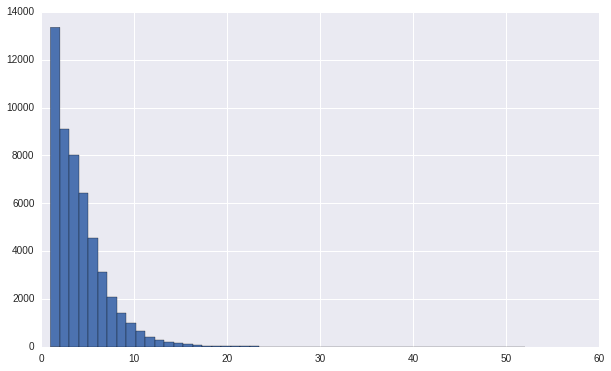

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as  plt
%matplotlib inline 
plt.rcParams['figure.figsize'] = (10, 6)

f = open(data_folder + '03_convNum.txt')
conv_num =[]
for i, line in enumerate(f):
    if i > 0:
        conv_num.append(int(line.strip()))
        
f = open(data_folder + '03_convLen.txt')
conv_len =[]
for i, line in enumerate(f):
    if i > 0:
        conv_len.append(int(line.strip()))

df = pd.DataFrame(zip(conv_num, conv_len), columns = ['ID', 'length'])
len_of_convs = df.groupby('ID')['length'].mean()
len_of_convs.hist(bins=50)

## Remove stopwords

Remove stopwords and punctuation from both client and agent messages, and create concatened message corpus, where each line has a question from the client and an answer from the agent.

In [56]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from itertools import izip

# load stopwords
stop = set(stopwords.words('english'))
# regexp for removing punctuation
tokenizer = RegexpTokenizer(r'\w+')

# open files for filtering
client_messages = codecs.open(data_folder + '03_clientMessages.txt', 'rU', 'utf-8')
client_messages2 = codecs.open(data_folder + '03_clientMessagesMatch04.txt', 'w', 'utf-8')
client_messages_filtered = codecs.open(data_folder + '04_clientMessagesFiltered.txt', 'w', 'utf-8')
agent_messages = codecs.open(data_folder + '03_agentMessages.txt', 'rU', 'utf-8')
agent_messages2 = codecs.open(data_folder + '03_agentMessagesMatch04.txt', 'w', 'utf-8')
agent_messages_filtered = codecs.open(data_folder + '04_agentMessagesFiltered.txt', 'w', 'utf-8')
client_agent_messages_filtered = codecs.open(data_folder + '04_clientAgentMessagesFiltered.txt', 'w', 'utf-8')

def join_line(line_list):
    """
    Joins a list of strings into one string.
    """
    return ' '.join(line_list)

with client_messages as client, agent_messages as agent: 
    for client_line, agent_line in izip(client, agent):
        no_punctuation_client = join_line(tokenizer.tokenize(client_line))
        no_punctuation_agent = join_line(tokenizer.tokenize(agent_line))
        
        if len(no_punctuation_client) > 0 and len(no_punctuation_agent) > 0:
            no_punctuation_client = no_punctuation_client.lower().split()
            no_punctuation_agent = no_punctuation_agent.lower().split()
            no_stopwords_client = [w for w in no_punctuation_client if w not in stop]
            no_stopwords_agent = [w for w in no_punctuation_agent if w not in stop]

            if len(no_stopwords_client) > 0 and len(no_stopwords_agent) > 0:
                no_stopwords_client = join_line(no_stopwords_client)
                no_stopwords_agent = join_line(no_stopwords_agent)
                client_messages2.write(client_line)
                agent_messages2.write(agent_line)
                client_messages_filtered.write(no_stopwords_client + '\n')
                agent_messages_filtered.write(no_stopwords_agent + '\n')
                client_agent_messages_filtered.write(no_stopwords_client + ' ' + no_stopwords_agent + '\n')

## Merge phrases of bigrams and trigrams

Adapted from Walter's feature_extraction notebook. It will group together common phrases like thank you as thank_you.

Creates __05_clientMessagesFiltered_trigram__, __05_agentMessagesFiltered_trigram__, __05_clientAgentMessagesFiltered_trigram__. 

In [14]:
import gensim as gs
files = ["04_clientMessagesFiltered", "04_agentMessagesFiltered", "04_clientAgentMessagesFiltered"]

for f in files:
    file_open = codecs.open(data_folder + f + '.txt','r','utf-8')
    chats = []
    for line in file_open:
        chats.append(line.strip().split())
        
    # find collections 
    bigram = gs.models.Phrases(chats)
    trigram = gs.models.Phrases(bigram[chats])
    
    
    # write results
    filename = f.split('_')[1]
    outfile = codecs.open(data_folder + '05_' + filename  + "_bigram.txt", 'w', 'utf-8')
    for sentence in list(bigram[chats]):
        try:
            outfile.write(" ".join(sentence) + "\n")
        except:
            pass
    outfile = codecs.open(data_folder + '05_' + filename + "_trigram.txt", 'w', 'utf-8')
    for sentence in list(trigram[chats]):
        try:
            outfile.write(" ".join(sentence) + "\n")
        except:
            pass

## Generate vectors for each sentence using the W2V models of Nico

In [5]:
import os
import numpy as np
import gensim as gs
# Load model
model = gs.models.Word2Vec.load(os.path.join(data_folder, 'clientW2V_BothSeperate'))

# Load client text and calculate average word vector
client_file = codecs.open(data_folder + '04_clientMessagesFiltered.txt', 'r', 'utf-8')

sentence_vects = []
for i, sentence in enumerate(client_file):
    sentence_matrix = np.array([model[w].T for w in sentence.strip().split() if w in model])
    sentence_vect = np.mean(sentence_matrix, axis=0)
    try:
        sentence_vects.append(sentence_vect)
    except:
        pass

/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [6]:
client_sentences = np.zeros((len(sentence_vects), 100))
for i, sentence in enumerate(sentence_vects):
    client_sentences[i, :] = np.array(sentence)

## Train KD Tree, define lookup function, save  and load KD Tree

In [7]:
def get_sentence_vector(sentence):
    sentence_matrix = np.array([model[w].T for w in sentence.strip().split() if w in model])
    sentence_vect = np.mean(sentence_matrix, axis=0)
    return sentence_vect

In [8]:
from sklearn.neighbors import KDTree
tree = KDTree(client_sentences)

In [48]:
import cPickle
# save the classifier
with open(data_folder + 'kdtree.pkl', 'wb') as fid:
    cPickle.dump(tree, fid)

In [4]:
# load it again
with open(data_folder + 'kdtree.pkl', 'rb') as fid:
    tree = cPickle.load(fid)

ValueError: unsupported pickle protocol: 3

## Test preliminary model with query sentences

In [59]:
query = 'i want to reschedule my delivery date'
query = 'i think my order got lost'
query = 'cannot log into my account'
dist, ind = tree.query(get_sentence_vector(query), k=1)

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [60]:
client_file = codecs.open(data_folder + '03_clientMessagesMatch04.txt', 'r', 'utf-8')
agent_file = codecs.open(data_folder + '03_agentMessagesMatch04.txt', 'r', 'utf-8')
for i, line in enumerate(client_file):
    if i == ind[0][0]:
        print 'CLIENT: ', line
for i, line in enumerate(agent_file):
    if i == ind[0][0]:
        print 'AGENT: ', line

CLIENT:  I cannot log into my account 

AGENT:  i am sorry to hear that Elizabeth. Could you please tell me what error you are getting, when you are trying to login.



## beta chatbot v. 001

In [ ]:
import warnings
warnings.filterwarnings('ignore')

def lookup_answer(query):
    try:
        dist, ind = tree.query(get_sentence_vector(query.lower()), k=1)
        agent_file = codecs.open(data_folder + '03_agentMessagesMatch04.txt', 'r', 'utf-8')
        client_file = codecs.open(data_folder + '03_clientMessagesMatch04.txt', 'r', 'utf-8')
        for i, line in enumerate(agent_file):
            if i == ind[0][0]:
                agent_line = line
                break
        for i, line in enumerate(client_file):
            if i == ind[0][0]:
                client_line = line
                break
    except:
        agent_line = "Oops that didn't work. Try something else.."
        client_line = ''
            
    return agent_line, client_line
    
def chatbot():
    while True:
        agent_line, client_line = lookup_answer(raw_input())
        client_line = ("(%s)\n" % client_line.strip())
        print client_line, agent_line

chatbot()